In [1]:
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import distance_transform_edt
from skimage.util import view_as_windows

In [2]:
def fill_gaps(array, distance=5):
    """ Fill gaps in input raster

    Parameters
    ----------
    array : 2D numpy.array
        Raster with valid values and with nans
    distance : int
        Minimum size of gap to fill

    Returns
    -------
    array : 2D numpy.array
        Ratser with small gaps filled by nearest neigbour

    """
    dist, indi = distance_transform_edt(
        np.isnan(array),
        return_distances=True,
        return_indices=True)
    gpi = dist <= distance
    r,c = indi[:,gpi]
    array[gpi] = array[r,c]
    return array

def normalize_chl(array, percentiles=(1,99), lims=None, distance=2):
    """ Normalize input chlorophyll values """
    # Mask zero values with NaN
    array[array == 0] = np.nan
    # Apply log10 tranform to input values to match normal distribution
    array = np.log10(array)
    # Replace small gaps with nearest neigbour values
    array = fill_gaps(array, distance)
    # Compute min/max values
    if lims is None:
        lims = np.nanpercentile(array, percentiles)
    print(lims)
    # replace values outside range with min/max
    array[array < lims[0]] = lims[0]
    array[array > lims[1]] = lims[1]
    
    return array, lims

def augment_array(a):
    aug = [a]
    for i in range(3):
        aug.append(np.rot90(a, axes=(1,2)))
    aug = np.vstack(aug)
    aug = np.vstack([aug, np.fliplr(aug)])
    return aug

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (1,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same", kernel_regularizer = keras.regularizers.l2(l=0.01))(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same", kernel_regularizer = keras.regularizers.l2(l=0.01))(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same", kernel_regularizer = keras.regularizers.l2(l=0.01))(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same", kernel_regularizer = keras.regularizers.l2(l=0.01))(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same", kernel_regularizer = keras.regularizers.l2(l=0.01))(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same", kernel_regularizer = keras.regularizers.l2(l=0.01))(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same", kernel_regularizer = keras.regularizers.l2(l=0.01))(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [3]:
# load arrays into Python
dataset = np.load('S3A_OL_2_WFR_20200620T103116_CHL_LABELS.npz')
chl = dataset['chl'][:, ::2]
lbl = dataset['label'][:, ::2]
print(chl.shape, lbl.dtype, lbl.max())

chl, chl_lims = normalize_chl(chl)

(4091, 4050) float32 1.0
[-0.50393701  0.91338581]


/data1/antonk/miniconda/envs/ice/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less
/data1/antonk/miniconda/envs/ice/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater


In [4]:
dataset2 = np.load('S3B_OL_2_WFR_20200621T100505_CHL_LABELS.npz')
chl2 = dataset2['chl'][:, ::2]
lbl2 = dataset2['label'][:, ::2]
lbl2[lbl2 > 0] = 1
print(chl2.shape, lbl2.dtype, lbl2.max())

chl2, chl_lims = normalize_chl(chl2, lims=chl_lims, distance=5)

(4091, 4050) float32 1.0
[-0.50393701  0.91338581]


/data1/antonk/miniconda/envs/ice/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less
/data1/antonk/miniconda/envs/ice/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater


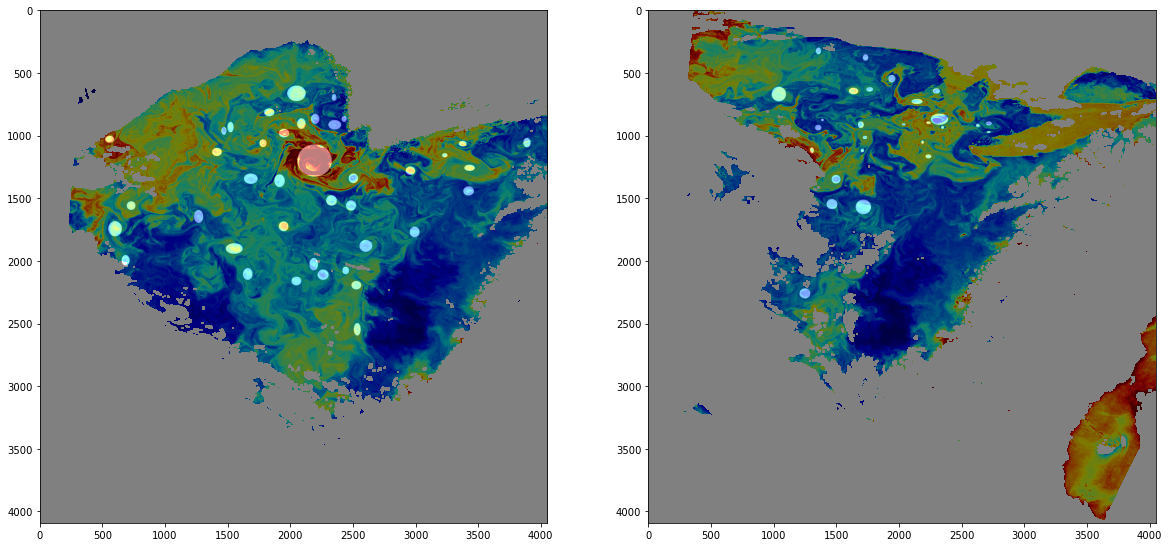

In [5]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(chl, cmap='jet')
ax[0].imshow(lbl, cmap='gray', alpha=0.5)

ax[1].imshow(chl2, cmap='jet')
ax[1].imshow(lbl2, cmap='gray', alpha=0.5)

plt.show()

In [6]:
ws_list = [128]
cnn_data = {}
# size of patch
for ws in ws_list:
    print('Window size:', ws)
    stp = 64 # step, at which the patches are sampled
    cnn_data[ws] = {'x': [], 'y': []}
    for chli, lbli in zip([chl, chl2], [lbl, lbl2]):
        chl_w = view_as_windows(chli, ws, stp)
        lbl_w = view_as_windows(lbli, ws, stp)

        # reshape from (N_row_patches x N_col_patches x Patch_height x Patch_width)
        # into (N_patches x Patch_height x Patch_width)
        wshape = chl_w.shape
        chl_w = chl_w.reshape(wshape[0]*wshape[1], wshape[2], wshape[3])
        lbl_w = lbl_w.reshape(wshape[0]*wshape[1], wshape[2], wshape[3])

        # Find valid patches (without NaN)
        valid = np.where(np.isfinite(np.min(chl_w, axis=(1,2))) * (np.sum(lbl_w, axis=(1,2)) > 10))[0]
        print('Shape of valid samples ', lbl_w[valid].shape)

        # Subsample only valid patches and reshape into 
        # N_samples x Height x Width x 1
        x = chl_w[valid]
        y = lbl_w[valid]
        x.shape += (1,)
        y.shape += (1,)

        x = augment_array(x)
        y = augment_array(y)
        
        print('Shape of input/output data ', x.shape, y.shape)
        print('No-eddie pixels: ', np.where(y == 0)[0].size, 'Eddie pixels ', np.where(y == 1)[0].size)
        cnn_data[ws]['x'].append(x)
        cnn_data[ws]['y'].append(y)

Window size: 128
Shape of valid samples  (325, 128, 128)
Shape of input/output data  (2600, 128, 128, 1) (2600, 128, 128, 1)
No-eddie pixels:  35651672 Eddie pixels  6946728
Shape of valid samples  (159, 128, 128)
Shape of input/output data  (1272, 128, 128, 1) (1272, 128, 128, 1)
No-eddie pixels:  18742088 Eddie pixels  2098360


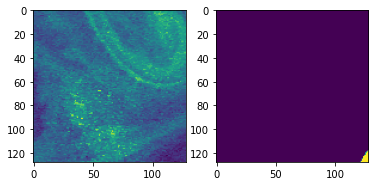

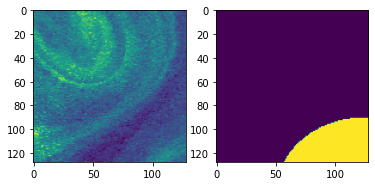

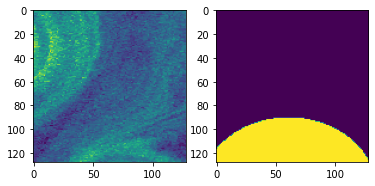

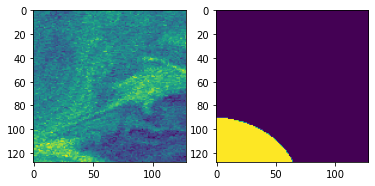

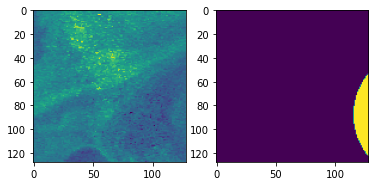

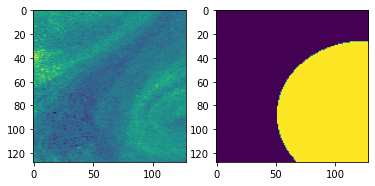

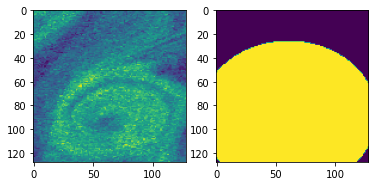

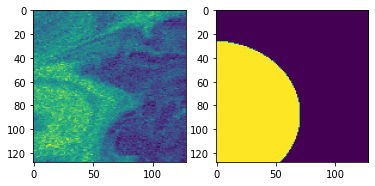

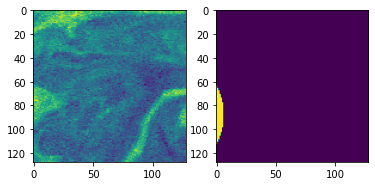

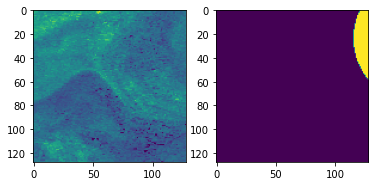

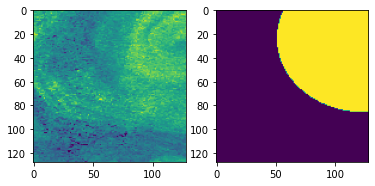

In [8]:
# Plot few patches with large labels
max_plots = 10
k = 0
for x1, y1 in zip(cnn_data[ws]['x'][0], cnn_data[ws]['y'][0]):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(x1[:,:,0])
    ax[1].imshow(y1[:,:,0])
    plt.show()
    k += 1
    if k > max_plots:
        break

In [ ]:
epochs = 100
batch_size = 64
optimizer="adam"
#optimizer="rmsprop"
loss="binary_crossentropy"

for ws in ws_list:
    print('Window size:', ws)
    cnn_filename = f'chl_eddies_unet_{ws}_cnn.h5'
    hist_filename = f'chl_eddies_unet_{ws}_history.npz'

    keras.backend.clear_session()

    model = get_model((ws,ws), 1)
    print(model.summary())

    model.compile(optimizer=optimizer, loss=loss)

    callbacks = [
        keras.callbacks.EarlyStopping(patience=5, verbose=1, restore_best_weights=True),
        keras.callbacks.ModelCheckpoint(cnn_filename, save_best_only=True, verbose=1),
    ]

    h1 = model.fit(cnn_data[ws]['x'][0], cnn_data[ws]['y'][0], 
                   validation_data=(cnn_data[ws]['x'][1], cnn_data[ws]['y'][1]), 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   callbacks=callbacks)
    np.savez(hist_filename, history=h1.history)


Window size: 128
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 32)   0           batch_normalization[0][0]        
_____________________________________________________________________________

Epoch 1/100
41/41 [==============================] - 85s 2s/step - loss: 17.4181 - val_loss: 13.8008

Epoch 00001: val_loss improved from inf to 13.80079, saving model to chl_eddies_unet_128_cnn.h5
Epoch 2/100


/data1/antonk/miniconda/envs/ice/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


41/41 [==============================] - 75s 2s/step - loss: 11.3779 - val_loss: 9.5894

Epoch 00002: val_loss improved from 13.80079 to 9.58941, saving model to chl_eddies_unet_128_cnn.h5
Epoch 3/100
41/41 [==============================] - 73s 2s/step - loss: 8.0242 - val_loss: 7.0285

Epoch 00003: val_loss improved from 9.58941 to 7.02846, saving model to chl_eddies_unet_128_cnn.h5
Epoch 4/100
41/41 [==============================] - 74s 2s/step - loss: 5.9571 - val_loss: 5.3378

Epoch 00004: val_loss improved from 7.02846 to 5.33784, saving model to chl_eddies_unet_128_cnn.h5
Epoch 5/100
41/41 [==============================] - 73s 2s/step - loss: 4.5509 - val_loss: 4.1733

Epoch 00005: val_loss improved from 5.33784 to 4.17335, saving model to chl_eddies_unet_128_cnn.h5
Epoch 6/100
41/41 [==============================] - 74s 2s/step - loss: 3.5580 - val_loss: 3.3036

Epoch 00006: val_loss improved from 4.17335 to 3.30359, saving model to chl_eddies_unet_128_cnn.h5
Epoch 7/100
41/

Window size: 64


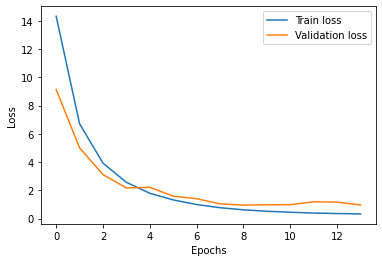

Window size: 128


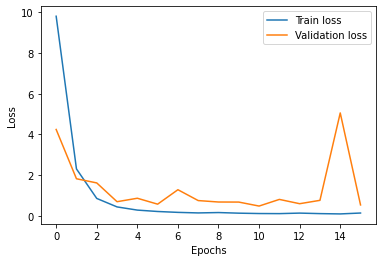

Window size: 256


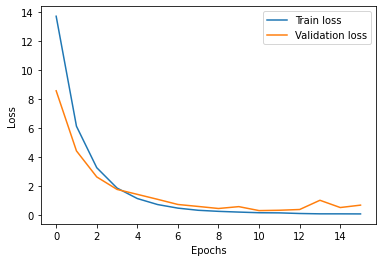

In [37]:
ws_list = [64, 128, 256]
for ws in ws_list:
    print('Window size:', ws)
    hist_filename = f'chl_eddies_unet_{ws}_history.npz'
    history = np.load(hist_filename, allow_pickle=True)['history'].item()
    plt.plot(history['loss'], label='Train loss')
    plt.plot(history['val_loss'], label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [38]:
for ws in ws_list:
    print('Window size:', ws)
    cnn_filename = f'chl_eddies_unet_{ws}_cnn.h5'
    res_filename = f'chl_eddies_unet_{ws}_results.npz'
    
    model = get_model((ws,ws), 1)
    model.load_weights(cnn_filename)

    ws_all = ws
    stp_all = int(ws / 2)
    labels_pred = []
    for chli in [chl, chl2]:
        chl_all = view_as_windows(chli, ws_all, stp_all)
        wshape_all = chl_all.shape
        print(chl_all.shape)

        x_all = chl_all.reshape(wshape_all[0]*wshape_all[1], wshape_all[2], wshape_all[3])
        x_all.shape += (1,)
        print(x_all.shape)

        y_all = model.predict(x_all)

        lbl_all_pred = y_all.reshape(chl_all.shape)
        lbl_pred = np.zeros_like(chli)

        rows = range(0, chli.shape[0], stp_all)[:-2]
        cols = range(0, chli.shape[1], stp_all)[:-2]
        print(len(rows), len(cols))
        for r, row in enumerate(rows):
            for c, col in enumerate(cols):
                lbl_pred[row:row+ws_all, col:col+ws_all] += lbl_all_pred[r, c]
        labels_pred.append(lbl_pred)

    np.savez(res_filename, labels_pred=labels_pred)

Window size: 64
(126, 125, 64, 64)
(15750, 64, 64, 1)
126 125
(126, 125, 64, 64)
(15750, 64, 64, 1)
126 125
Window size: 128
(62, 62, 128, 128)
(3844, 128, 128, 1)
62 62
(62, 62, 128, 128)
(3844, 128, 128, 1)
62 62
Window size: 256
(30, 30, 256, 256)
(900, 256, 256, 1)
30 30
(30, 30, 256, 256)
(900, 256, 256, 1)
30 30


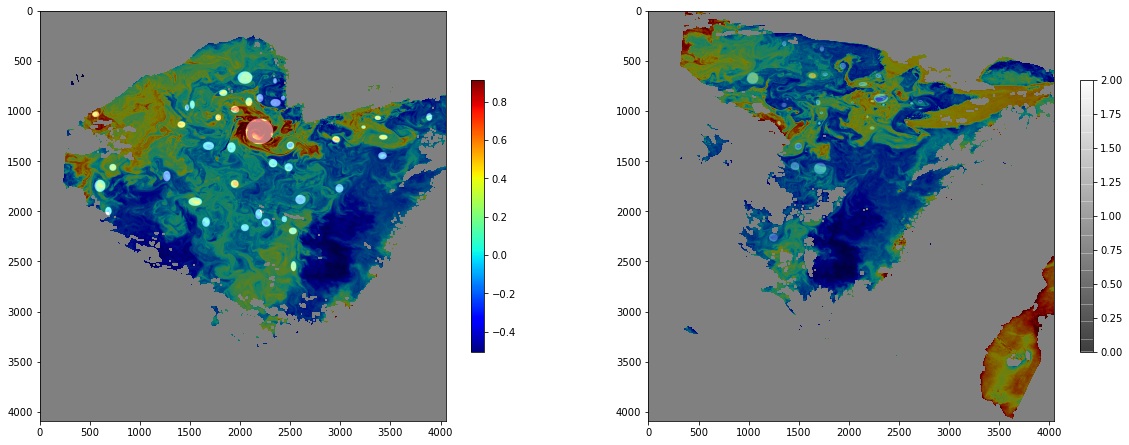

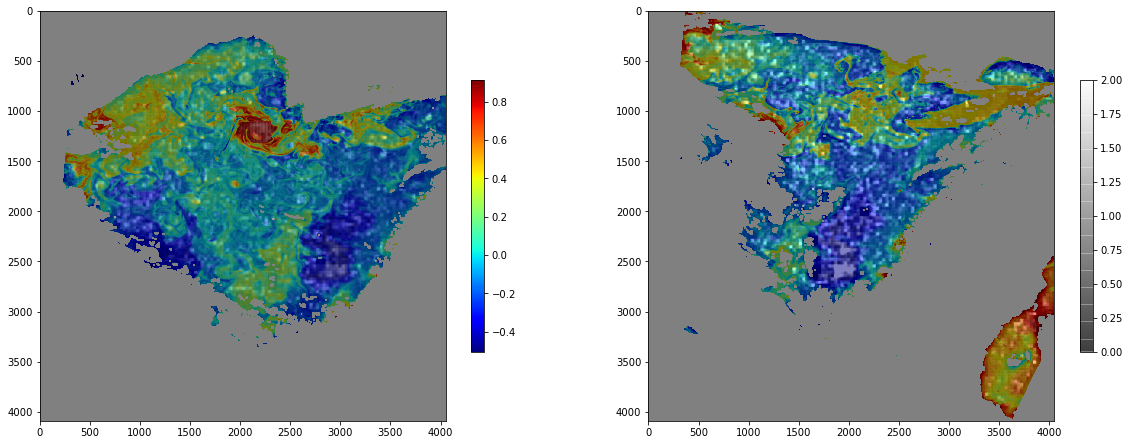

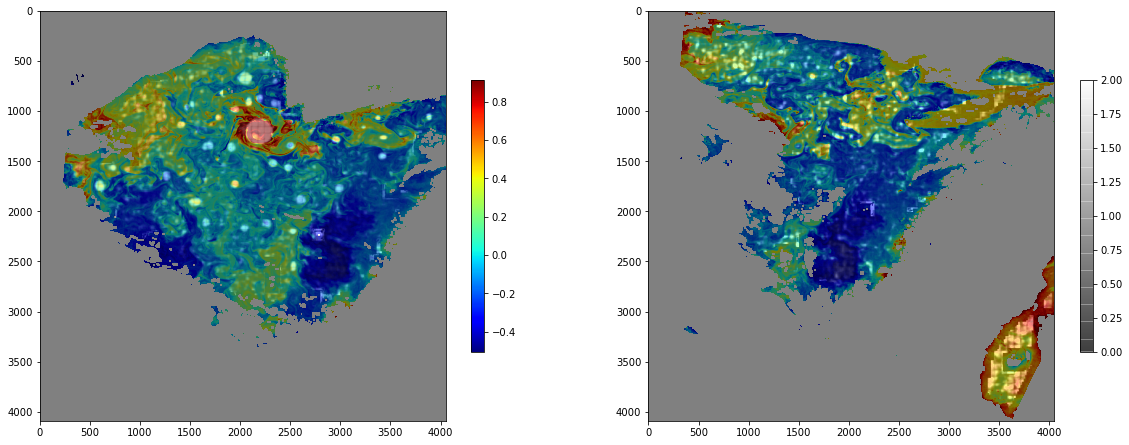

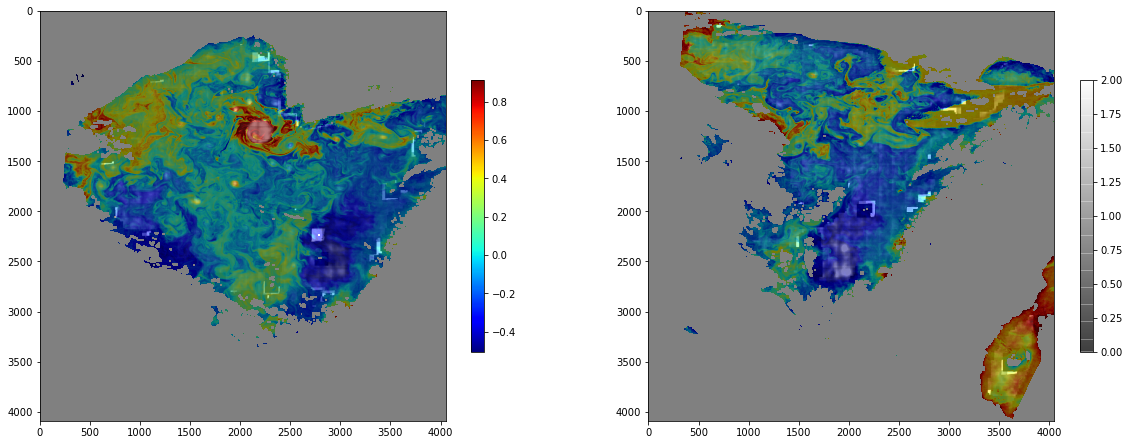

In [42]:
def plot_maps(arr1, mask1, arr2, mask2, clim=(0, 2)):
    fig, ax = plt.subplots(1,2,figsize=(20,10))
    im0 = ax[0].imshow(arr1, cmap='jet')
    ax[0].imshow(mask1, cmap='gray', alpha=0.5)
    fig.colorbar(im0, ax=ax[0], shrink=0.5)

    ax[1].imshow(arr2, cmap='jet')
    im1 = ax[1].imshow(mask2, clim=clim, cmap='gray', alpha=0.5)
    fig.colorbar(im1, ax=ax[1], shrink=0.5)
    plt.show()

plot_maps(chl, lbl, chl2, lbl2)

for ws in ws_list:
    lbl_cnn_1, lbl_cnn_2  = np.load(f'chl_eddies_unet_{ws}_results.npz')['labels_pred']

    for i in [lbl_cnn_1, lbl_cnn_2]:
        i[np.isnan(i)] = 0

    plot_maps(chl, lbl_cnn_1, chl2, lbl_cnn_2)


IndexError: index 2 is out of bounds for axis 0 with size 2

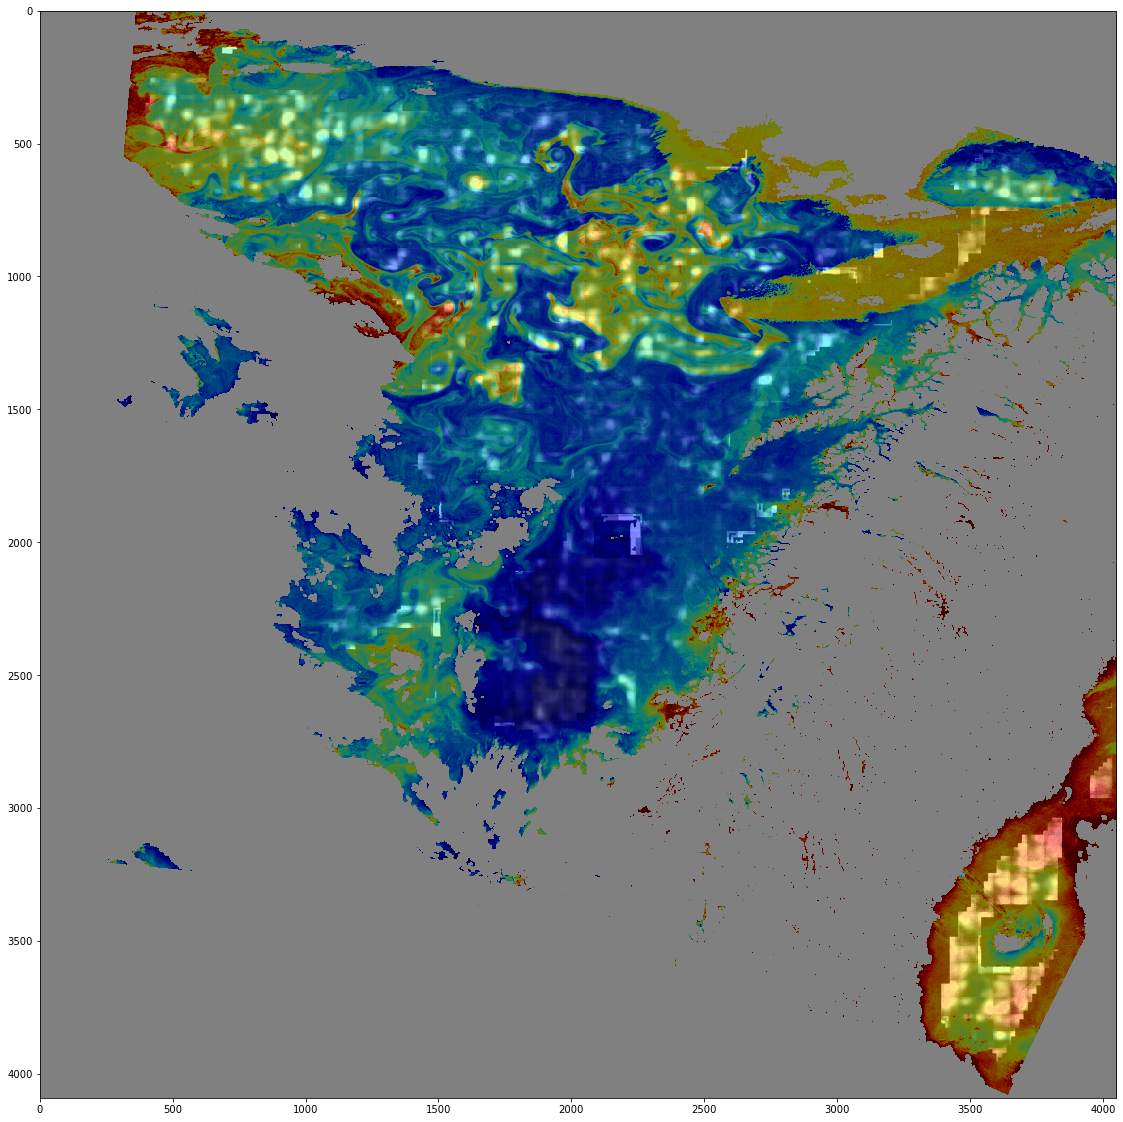

In [43]:
clim = [0, 2]
plt.figure(figsize=(20,20))
plt.imshow(chl2, cmap='jet')
im2 = plt.imshow(lbl_128_2, clim=clim, cmap='gray', alpha=0.5)
fig.colorbar(im2, ax=ax[2], shrink=0.5)
plt.show()